# Krypton average corrections

## Correct energy using Kr XY maps and obtain resolution

#### This is the average correction on the whole period computed using the average maps.

- In this NB we use the same data that was used to compute average maps (one single time bin) to compute energy resolution. Notice that lifetime varies with time, but the average value of the lifetime corresponds to the average map, and thus the resolution should be close to optimal. 

-Notice that in general one wants to compute a time-dependent correction. We study this case in another NB.

### Author:  JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last updated on  Fri Oct 12 19:11:36 2018


In [4]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')



2018-10-12 19:11:37,975 | INFO : Hello world!


### Input files

In [7]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6350_trigger1_0000_9564.h5',
                     'dst_6351_trigger1_0000_9580.h5',
                     'dst_6352_trigger1_0000_9838.h5',
                     'dst_6353_trigger1_0000_9453.h5']

output_file_name  = 'dst_6350_6353_lt0.h5'
map_file_name     = 'kr_maps_xy_6350_6353.h5'
map_file_name_ts  = 'kr_maps_xy_ts_6350_6353.h5'
emap_file_name    = 'kr_emap_xy_6350_6353.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [9]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [10]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [11]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [12]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_energy_map
from krcal.core.io_functions       import read_energy_map
from krcal.core.io_functions       import read_maps_ts

In [13]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN

In [14]:
from krcal.core.plt_functions       import plot_sector
from krcal.core.plt_functions       import plot_sectors

In [15]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import events_sector
from krcal.core.analysis_functions      import event_map
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [16]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [17]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [18]:
from krcal.core.fit_lt_histograms    import histo_fit_sectors
from krcal.core.fit_lt_histograms    import print_fit_sectors_pars
from krcal.core.fit_lt_histograms    import plot_fit_sectors
from krcal.core.fit_lt_histograms    import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms    import print_fit_lifetime

In [19]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [22]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_alpha_map
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [23]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average

In [24]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [25]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [27]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [28]:
import krcal.dev.corrections       as corrections 


In [29]:
from numpy import pi

In [30]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [31]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [32]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6350_trigger1_0000_9564.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6351_trigger1_0000_9580.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6352_trigger1_0000_9838.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6353_trigger1_0000_9453.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/dst_6350_6353_lt0.h5', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_xy_6350_6353.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_xy_ts_6350_6353.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_6350_6353.h5')

In [33]:
fn.output_file_name

'/Users/jjgomezcadenas/Projects/ICDATA/ldst/dst_6350_6353_lt0.h5'

In [34]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [35]:
#unique_events = ~dst.event.duplicated()
#number_of_evts_full = np.count_nonzero(unique_events)

# Above does not work when glueing multiple DSTs, events ARE duplicated,
# since event number starts at 0, rather than taking true event number. 

print(f"Total number of events: {len(dst)}")

Total number of events: 3938450


In [36]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [37]:
RMAX      = 200.
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)


krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [38]:
dst = dst[in_range(dst.R, 0, RMAX)]

In [39]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Raw S2 energy vs Z

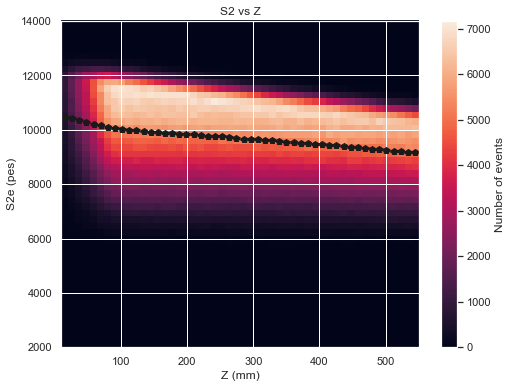

In [40]:
nevt = h2d(dst.Z, dst.S2e, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(8,6))

### Load energy map (computed with a single-bin of time)

In [41]:
amap = read_maps(fn.emap_file_name)

In [42]:
amap_average(amap)

ASectorMap(chi2=1.0881782907751534, e0=10241.244735326858, lt=3870.466695213109, e0u=0.30665045079459047, ltu=3.765809998776705)

In [43]:
norm = amap_max(amap)

In [44]:
norm

ASectorMap(chi2=282.0303296065546, e0=12718.279629341332, lt=5994.043400113501, e0u=1.4286145265387942, ltu=43.24019750353555)

In [45]:
print(f'normalizing to {norm.e0}')

normalizing to 12718.279629341332


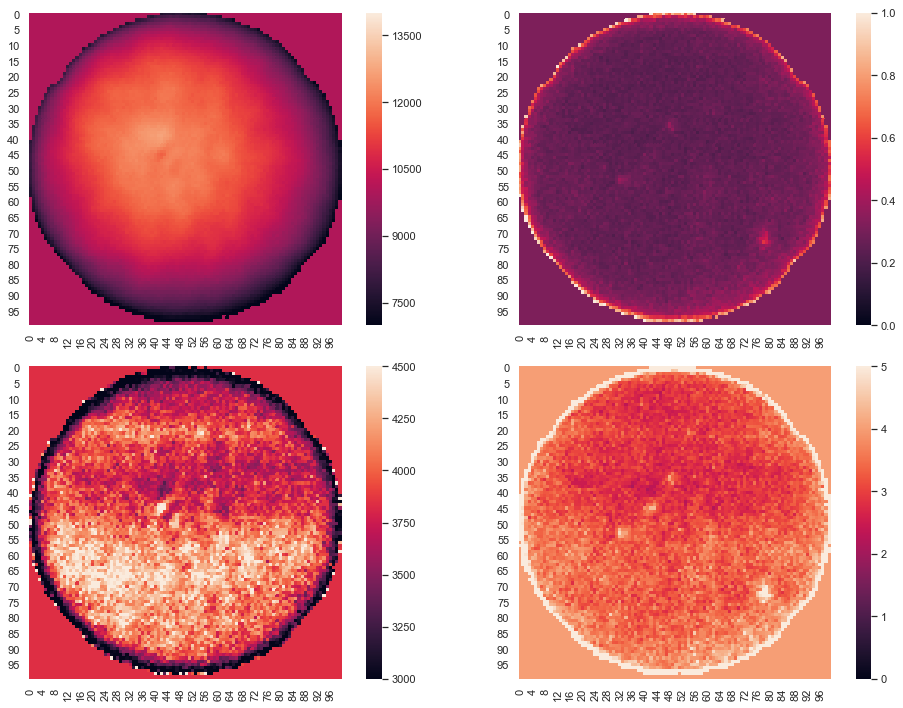

In [46]:
draw_xy_maps(amap,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 4500),
            eulims  = (0, 1),
            lulims  = (0, 5),
            figsize=(14,10))

### E0 (geometry) correction

In [47]:
t0 = time.time()
E0 = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = amap.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = krNbins.X, 
                      ny  = krNbins.Y)


t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 33.47356390953064


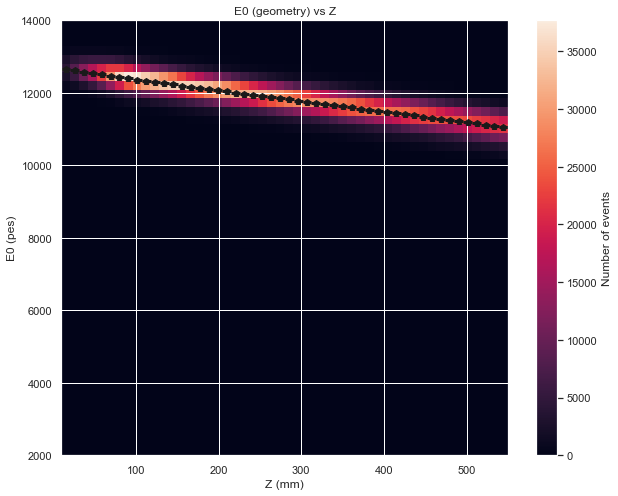

In [52]:
nevt = h2d(dst.Z, E0, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='E0 (pes)', title='E0 (geometry) vs Z'),
           profile=True,
           figsize=(10,8))

### This correction should be time independent, since the energy map should not change with time (or change very little).  

In [48]:
t0 = time.time()
E = lt_xy_correction(E0, 
                     dst.X.values, 
                     dst.Y.values,
                     dst.Z.values, 
                     LTM = amap.lt,
                     xr  = krRanges.X,
                     yr  = krRanges.Y,
                     nx  = krNbins.X, 
                     ny  = krNbins.Y)
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 32.49586606025696


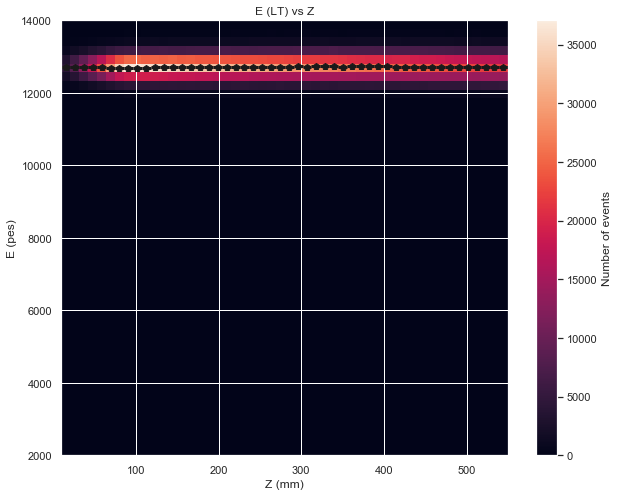

In [49]:
nevt = h2d(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='E (pes)', title='E (LT) vs Z'),
           profile=True,
           figsize=(10,8))

#### This correction is good for the full run, but should not be as good when one corrects a portion of the run (average lifetime map will differ from local value of lifetime)

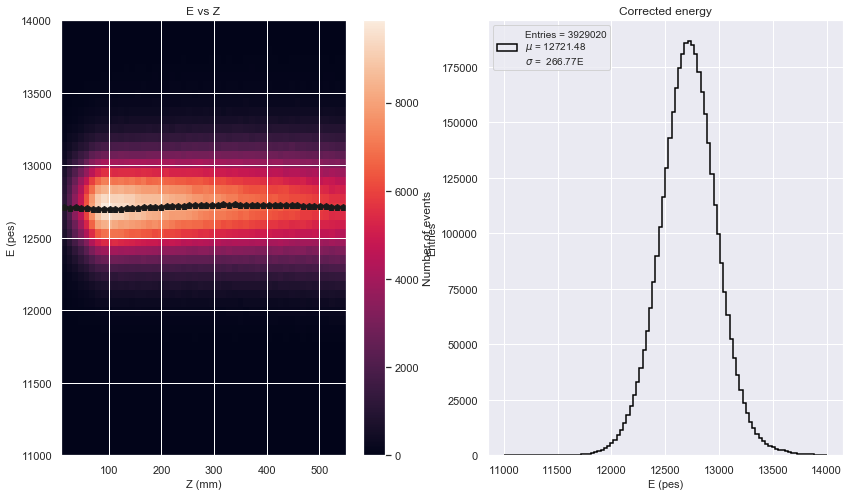

In [50]:
e_range = (11000, 14000)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range = e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Corrected energy'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12719.168648975987 +-0.132843424411566 
 E sigma   = 258.501191439731 +-0.1032190640128223 
 chi2    = 9.645881359842354 
 sigma E/E (FWHM)     (%) =4.776081021083681
 sigma E/E (FWHM) Qbb (%) =0.6168402075307681 


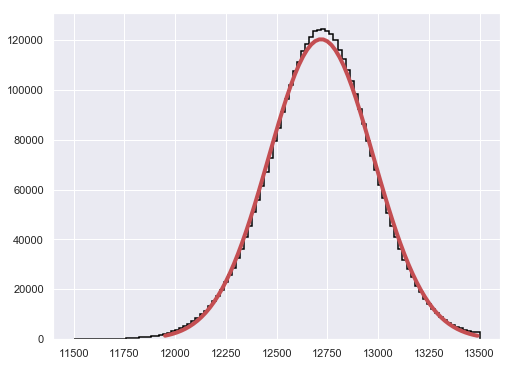

In [51]:
fc = fit_energy(E, nbins=100, range=(11500, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

In [52]:
kge = kr_event(dst, DT, E0, E0) 

In [53]:
kre = kr_event(dst, DT, E, E) 

### Time dependence

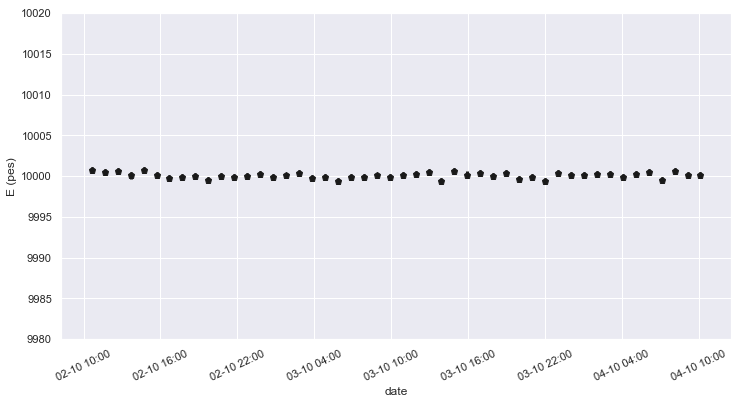

In [54]:
baseline = 10000
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(kge.T, kge.S2e, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(e1, e2),  
                    figsize=(12,6))

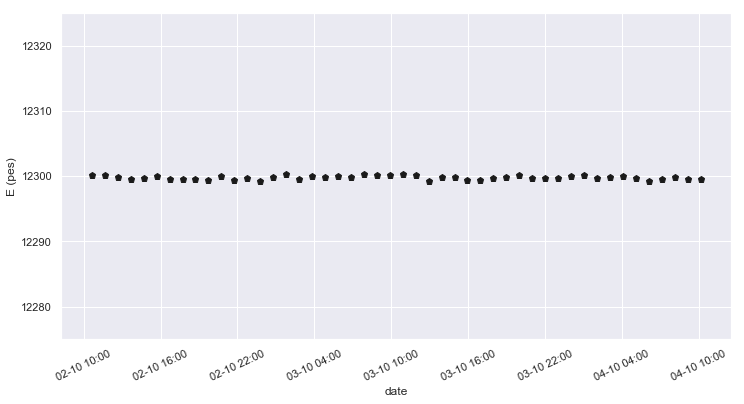

In [55]:
baseline = 12300
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(kge.T, kge.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(12275, 12325),
                    figsize=(12,6))

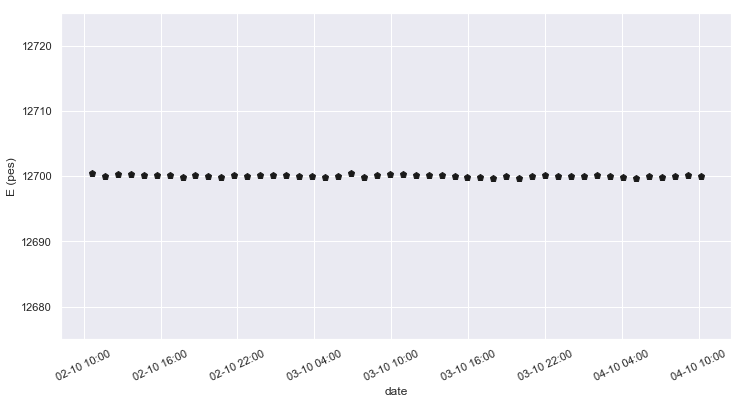

In [56]:
baseline = 12700
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(kre.T, kre.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(12675, 12725),
                    figsize=(12,6))

### Radial dependence

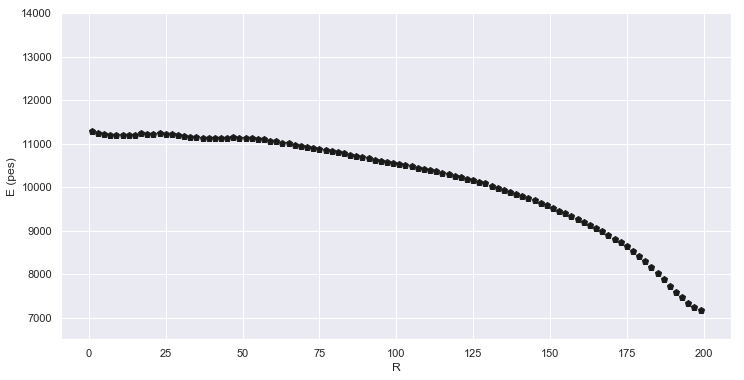

In [57]:
energy_X_profile(dst.R, dst.S2e, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

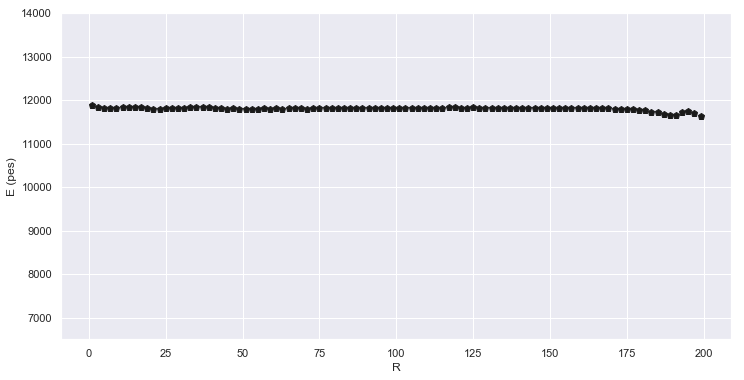

In [58]:
energy_X_profile(kge.R, kge.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

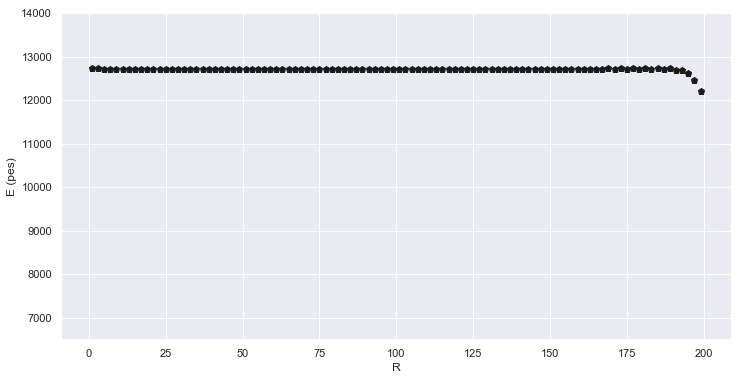

In [59]:
energy_X_profile(kre.R, kre.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

### Phi distribution

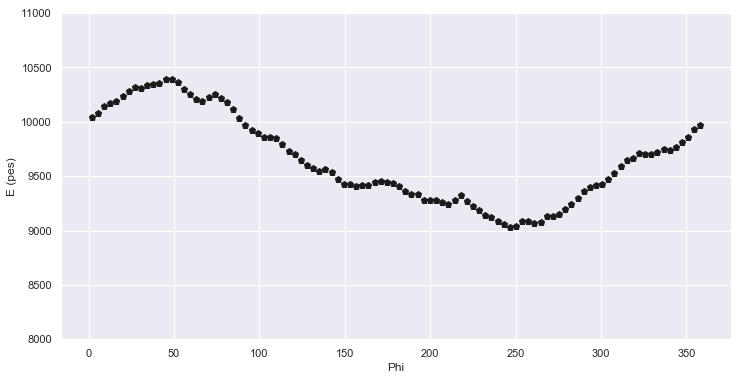

In [60]:
energy_X_profile(phirad_to_deg(dst.Phi), dst.S2e, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(8000, 11000),  
                 figsize=(12,6))

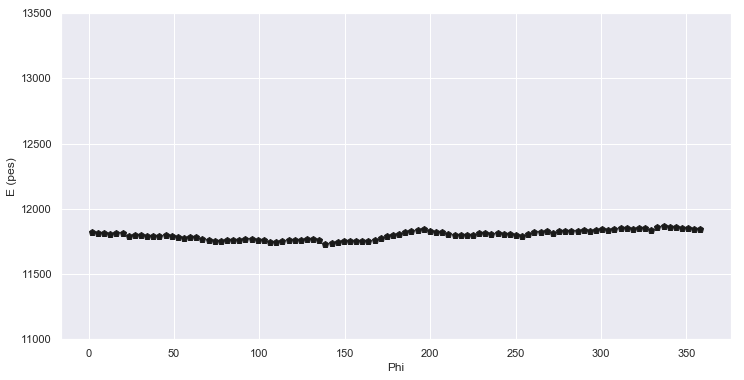

In [61]:
energy_X_profile(phirad_to_deg(kge.Phi), kge.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

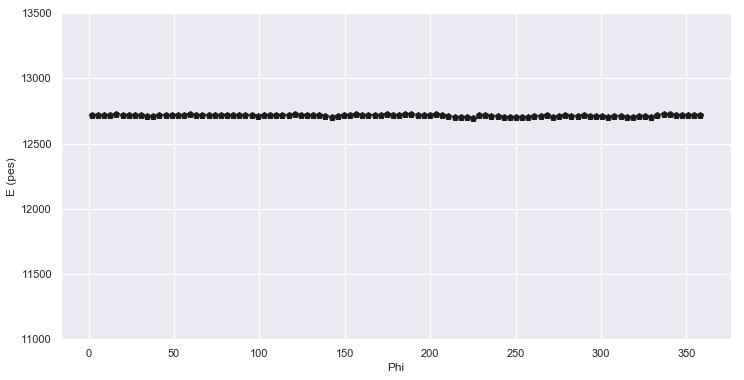

In [62]:
energy_X_profile(phirad_to_deg(kre.Phi), kre.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

### Dependence with Z

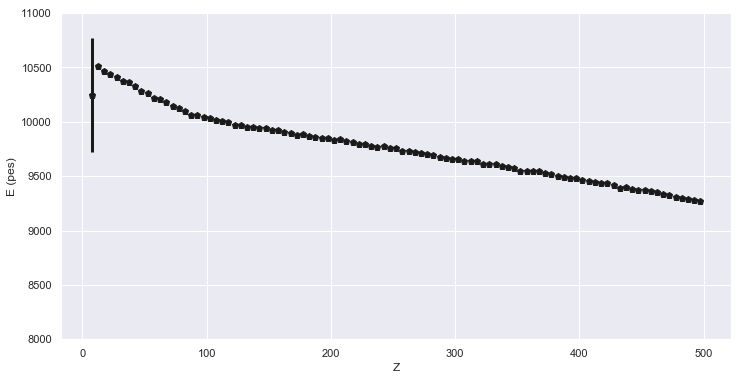

In [63]:
energy_X_profile(dst.Z, dst.S2e, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After: Lifetime corrected

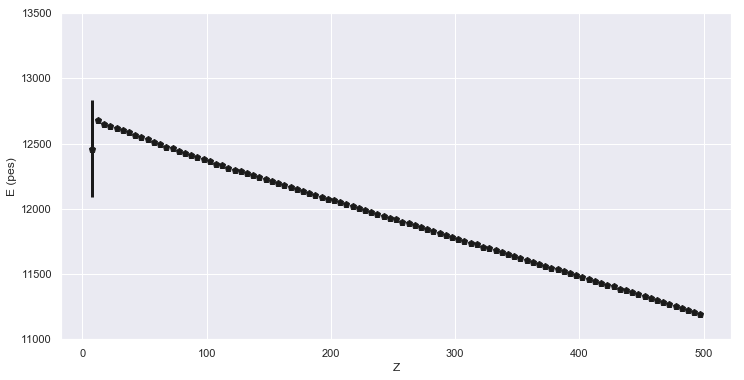

In [64]:
energy_X_profile(kge.Z, kge.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

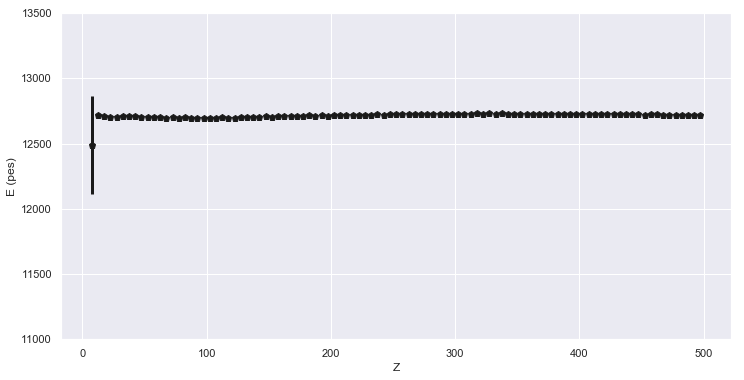

In [65]:
energy_X_profile(kre.Z, kre.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

### Time correction

(11000, 13500)

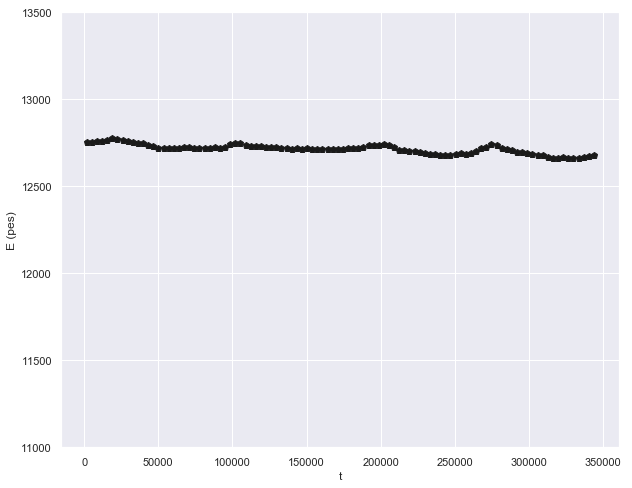

In [66]:
T   =(kre.T - kre.T.min()) 
t, e, eu = fitf.profileX(T, kre.E, 100)
erange =(11000, 13500)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [67]:
e_mu    = np.nanmean(kre.E)
print(e_mu)
e_std   = np.nanstd (kre.E)
print(e_std)

12716.99338000695
302.31711880746496


In [68]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = kre.E * ET_correction(T).value

(11000, 13500)

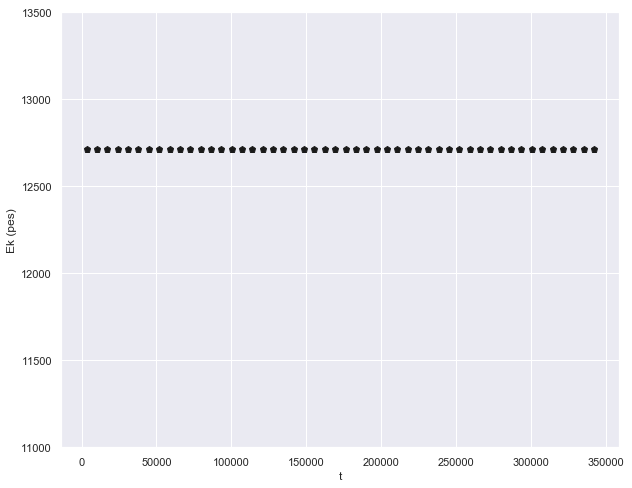

In [69]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

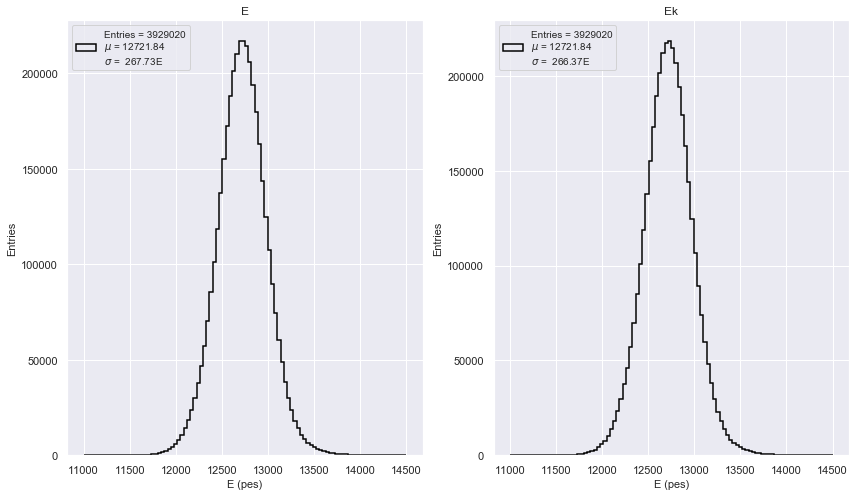

In [70]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(kre.E,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Ek'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12719.126418501402 +-0.13228010772848076 
 E sigma   = 257.3668847896999 +-0.10278626601100206 
 chi2    = 15.861003028170236 
 sigma E/E (FWHM)     (%) =4.755139302460484
 sigma E/E (FWHM) Qbb (%) =0.614135543601375 


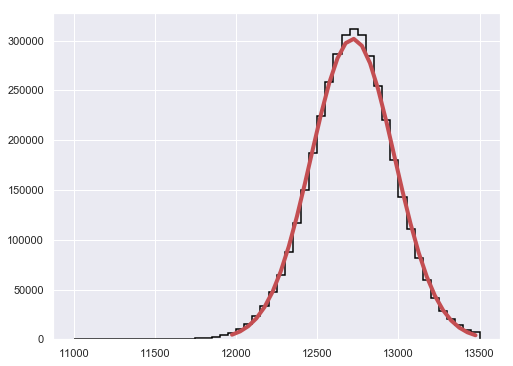

In [71]:
fc = fit_energy(Ek, nbins=50, range=(11000, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

### As a function of R and Z

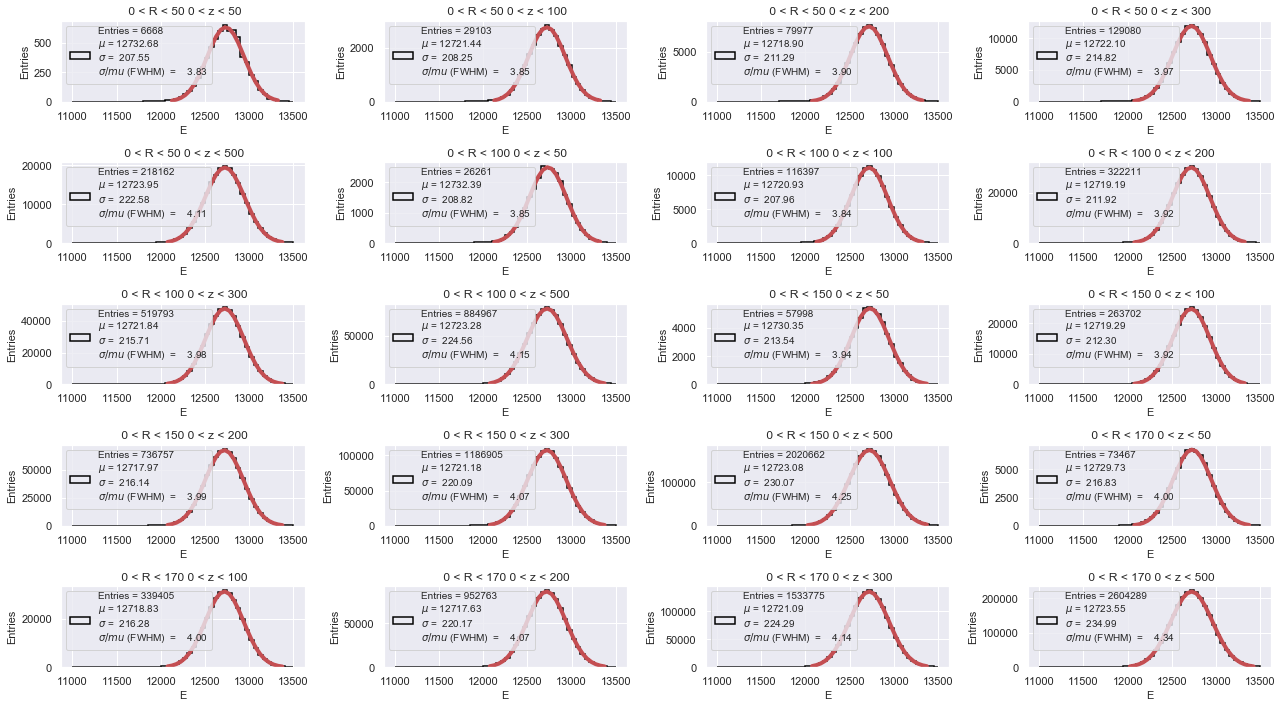

In [72]:
Ri = (50, 100,150,170)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, kre.R, kre.Z, Ek,
                    enbins = 50,
                    erange = (11e+3, 13500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))                                

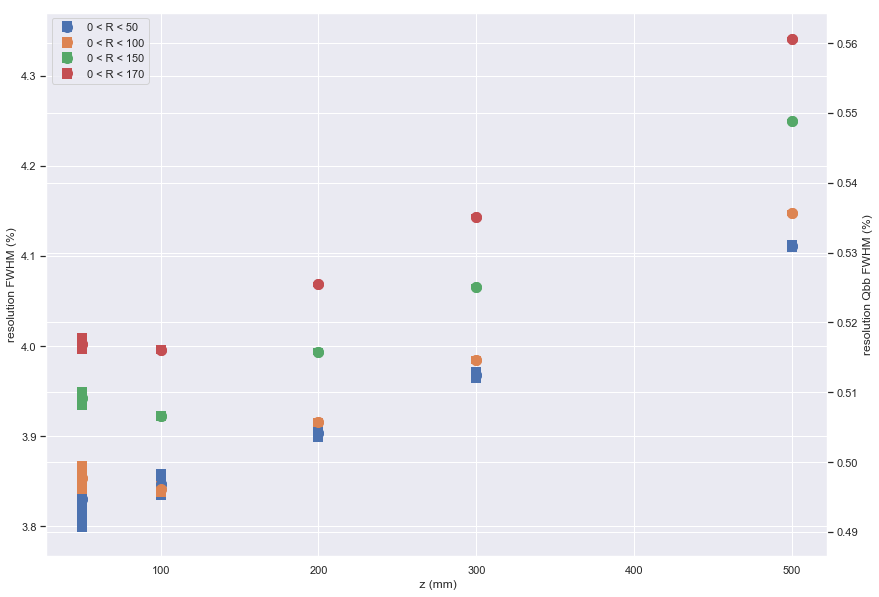

In [78]:
plot_resolution_r_z(Ri, Zi, FC, FCE)